In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint,
    plot_keypoints_IoU)

from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet, EfficentNet_3, EfficentNet_5

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.20 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] = 
%env WANDB_API_KEY = 

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/alex/Documents/new try/Lung Unet/compare_models.ipynb.


env: WANDB_API_KEY=32ba2dfcae28d5229d9da5ea919130a28f8ab52c


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: alexander-ortlieb94 (ulm-university). Use `wandb login --relogin` to force relogin


True

In [3]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
random.seed(42)
torch.manual_seed(42)

In [4]:
from Keypoint_dataset_gaussian_std import get_loader_keypoint_simulated

In [5]:
def get_acc_extra(model, data_loader, DEVICE = 'cuda:0'):
    loss_func = nn.MSELoss()
    model.eval()
    loss = 0
    IoU = 0
    with torch.no_grad():
        for image, targ in data_loader:
            img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
            target = targ.to(DEVICE)
            pred = model(img)
            loss += loss_func(pred, target.squeeze(1))
            IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
    model.train()
    print('Loss:', loss/len(data_loader), 'BoxIoU:', IoU/len(data_loader.dataset))
    return loss.item()/len(data_loader), IoU/len(data_loader.dataset)

In [6]:
def training(i, model, IMAGE_STD, NOISE_STD_RATIO):
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE)

    scaler = torch.cuda.amp.GradScaler()

    run = wandb.init(
                # set the wandb project where this run will be logged
                #entity = "alexander-ortlieb94",
                project = "Fixpoint detection effnet7",
                job_type = 'gaussian',
                name = 'EfficientNet',

            # track hyperparameters and run metadata
            config={
                "try no." : i,
                "std_matching" : IMAGE_STD,
                "std_noise_ratio" : NOISE_STD_RATIO
                },
    )


    train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(8, IMAGE_STD, NOISE_STD_RATIO)

    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader)
        for batch_idx, (img, target_keypoints) in enumerate(loop):
            img = img.to(device = DEVICE).repeat(1, 3, 1, 1)
            target_keypoints = target_keypoints.to(DEVICE)
            with torch.cuda.amp.autocast():
                predictions = model(img) # [k,8]
                loss = loss_func(predictions, target_keypoints.squeeze(1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loop.set_postfix(loss=loss.item())

        if epoch % 5 == 0:

            val_loss, val_iou = get_acc_extra(model, validation_loader)

            wandb.log(
                {
                    "val loss": val_loss,
                    "val Box IoU": val_iou
                }
            )
    
    test_loss, test_iou = get_acc_extra(model, test_loader)
    wandb.log(
            {
                "Test loss": test_loss,
                "Test Box IoU": test_iou
            }
        )
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
       
    save_path = f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficientNet_{IMAGE_STD}_{NOISE_STD_RATIO}_{i}.pth.tar'
    save_checkpoint(checkpoint, save_path)
    
    run.finish()
    del loss, predictions, test_loss, test_iou, model, val_loss, val_iou
    torch.cuda.empty_cache() 

In [7]:
list2= [10, 7, 13]
list1= [1, 0.5, 0.2, 0.1, 0.05, 0.2, 0.2]

inputs =[[x,y] for x in list2 for y in list1]

In [ ]:
for i in range(3,5):
    for IMAGE_STD, NOISE_STD_RATIO in inputs:
            model = EfficentNet().to(DEVICE)
            load_checkpoint(model, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_gaussian_0.pth.tar')
            training(i, model, IMAGE_STD, NOISE_STD_RATIO)


In [ ]:
train_loader, test_loader, validation_loader = get_loader_keypoint(BATCH_SIZE=8)
for i in range(2):
    run = wandb.init(
                # set the wandb project where this run will be logged
                #entity = "alexander-ortlieb94",
                project = "Fixpoint detection normal",
                job_type = 'normal',
                name = 'EfficentNet',
                
                config={
                "try no.": i
                },
    )
    model = EfficentNet().to(DEVICE)
    load_checkpoint(model, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_{i}.pth.tar')
    test_loss, test_iou = get_acc_extra(model, test_loader)
    wandb.log(
            {
                "Test loss": test_loss,
                "Test Box IoU": test_iou
            }
        )
    run.finish()

# Evaluation

In [ ]:
model = EfficentNet().to(DEVICE)
checkpoint = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_poisson_0.pth.tar'
load_checkpoint(model, checkpoint)

=> Loading checkpoint


In [9]:
from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)

def calculate_cropped_area_with_tolerance(preds, tolerance, device="cuda"):
    boxes = []
    preds = preds.cpu().detach().numpy().astype(np.uint8)
   
    keypoint_image = torch.zeros(image[0,0].shape)
    for i in range(0,8,2):
        keypoint_image[preds[0,i+1],preds[0,i]] = 1
    pred_box = masks_to_boxes(keypoint_image.unsqueeze(0))[0]

    pred_width = (pred_box[2] - pred_box[0]) + 2 * tolerance
    pred_height = (pred_box[3] - pred_box[1]) + 2 * tolerance

    # Calculate area of predicted box and ground truth box
    pred_area = pred_width * pred_height

    total_area = 195*195

    return pred_area / total_area

In [19]:
model = EfficentNet().to(DEVICE)
checkpoint = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_gaussian_0.pth.tar'
load_checkpoint(model, checkpoint)

model.eval()

tolerance = 10

from Keypoint_dataset_gaussian import get_loader_keypoint_simulated
train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(BATCH_SIZE=1)

reduced_areas = []
for i , (image, targ) in enumerate(test_loader):
    img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
    pred = model(img)
    area = calculate_cropped_area_with_tolerance(pred, tolerance, device="cuda")
    reduced_areas.append(max(0,1-area))

=> Loading checkpoint


In [20]:
reduced_areas = 100* np.array(reduced_areas)

25.76365544371409


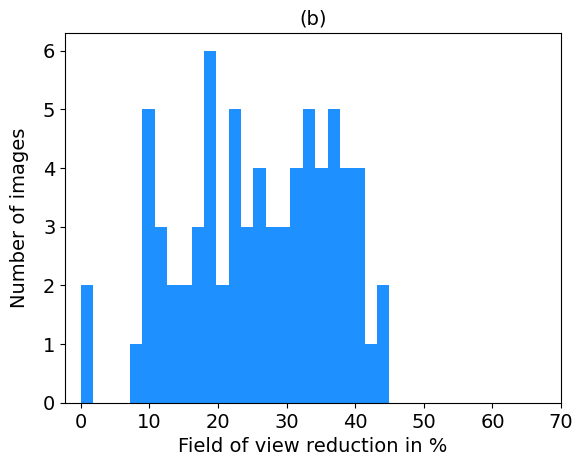

In [21]:
print(np.mean(reduced_areas))
plt.hist(reduced_areas, bins = 25, color = 'dodgerblue')#, range = (0, 0.5))
plt.xticks(np.arange(0, 80, step= 10))
plt.xlabel('Field of view reduction in %', size = 14)
plt.ylabel('Number of images', size = 14, labelpad=10) 
plt.title('(b)', size = 14)
plt.tick_params(axis='both', labelsize=14)
plt.savefig(r'/home/alex/Documents/Images_thesis/effnet_fov_reduction_with_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()

42.26196


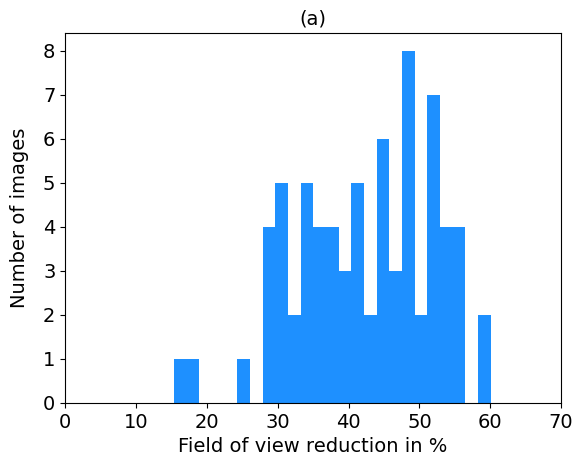

In [22]:
tolerance = 0

from Keypoint_dataset_gaussian import get_loader_keypoint_simulated
train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(BATCH_SIZE=1)

reduced_areas = []
for i , (image, targ) in enumerate(test_loader):
    img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
    pred = model(img)
    area = calculate_cropped_area_with_tolerance(pred, tolerance, device="cuda")
    reduced_areas.append(max(0,1-area))
reduced_areas = 100* np.array(reduced_areas)

print(np.mean(reduced_areas))
plt.hist(reduced_areas, bins = 25, color = 'dodgerblue')#, range = (0, 0.5))
plt.xticks(np.arange(0, 80, step= 10))
plt.xlabel('Field of view reduction in %', size = 14)
plt.ylabel('Number of images', size = 14, labelpad=10) 
plt.title('(a)', size = 14)
plt.tick_params(axis='both', labelsize=14)
plt.savefig(r'/home/alex/Documents/Images_thesis/effnet_fov_reduction_without_tolerance.svg', bbox_inches="tight", format="svg")
plt.show()

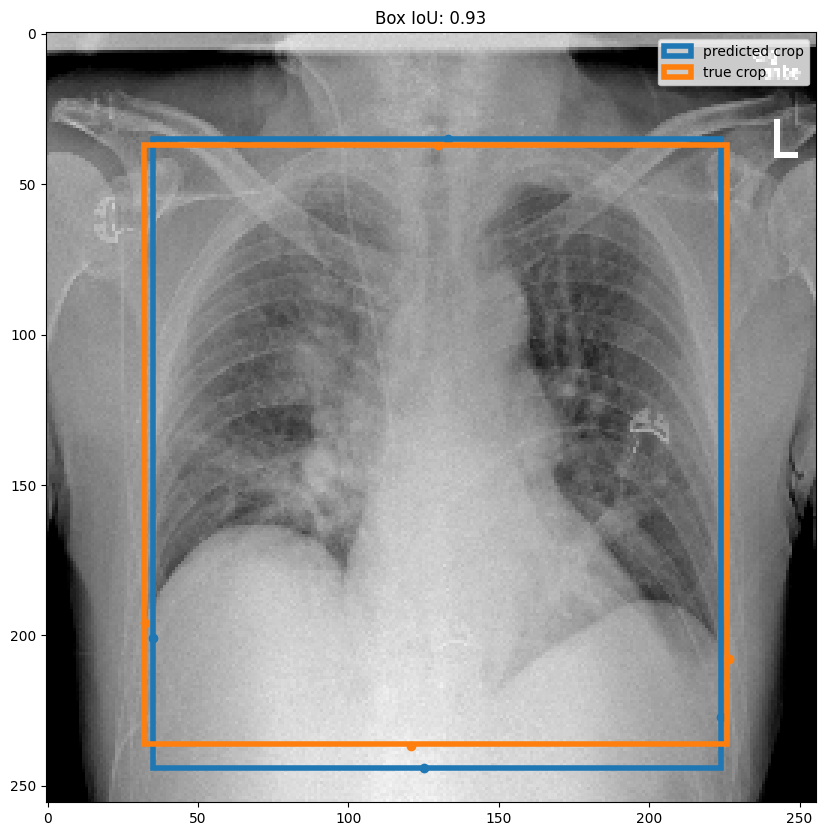

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.imshow(image[0,0], cmap ='gray')
    #pred_box = masks_to_boxes(keypoint_image.unsqueeze(0))[0]
boxes = []
pred_kp = pred_kp.cpu().detach().numpy().astype(np.uint8)
for keypoints in [kp.detach().numpy().astype(np.uint8), pred_kp]:
    keypoint_image = torch.zeros(image[0,0].shape)
    for i in range(0,8,2):
        keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1
    boxes.append(masks_to_boxes(keypoint_image.unsqueeze(0)))
test_box, pred_box = boxes[0][0], boxes[1][0]
for i in range(0,8,2):
    axs.scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C0')
    axs.scatter(kp[0,i],kp[0,i+1], color = 'C1')
rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0],
                                pred_box[3] - pred_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='predicted crop')
rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                test_box[3] - test_box[1], linewidth=4, edgecolor='C1', facecolor='none', label='true crop')

    #pred_rect_copy = copy(rect_pred)
axs.add_patch(rect_pred)
axs.add_patch(rect_test)
box_iou = generalized_box_iou(boxes[0], boxes[1])
box_iou = torch.nan_to_num(box_iou, 0)
box_iou = torch.trace(box_iou)
plt.title(f'Box IoU: {box_iou:.2f}')
plt.legend()
plt.show()

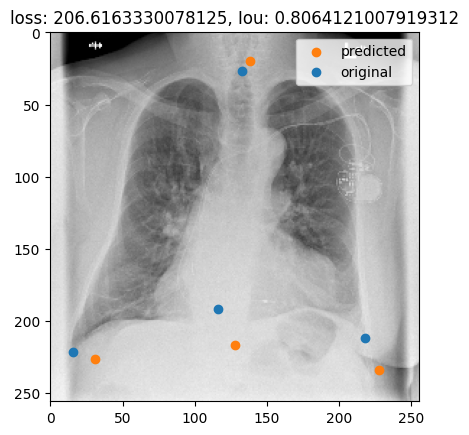

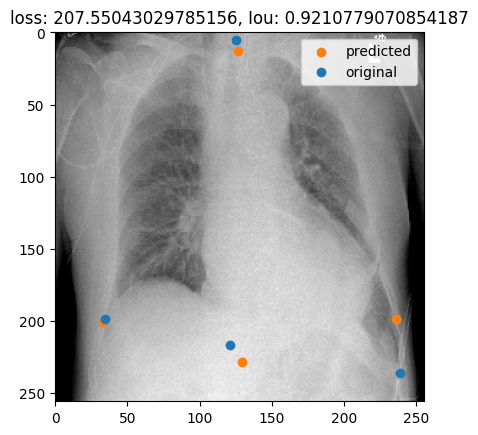

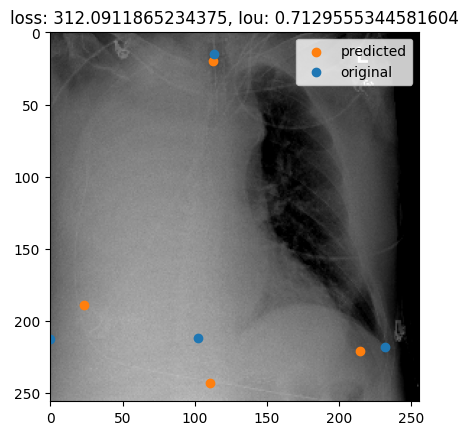

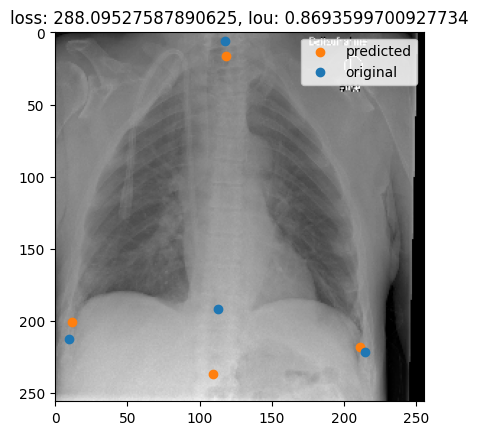

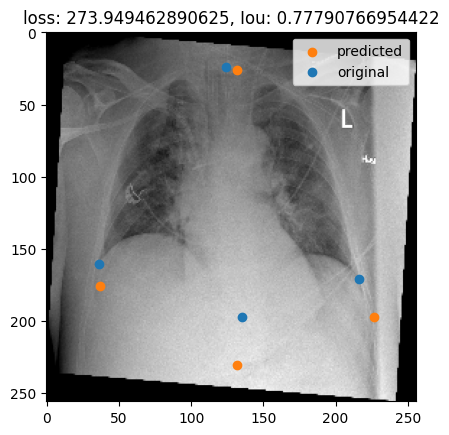

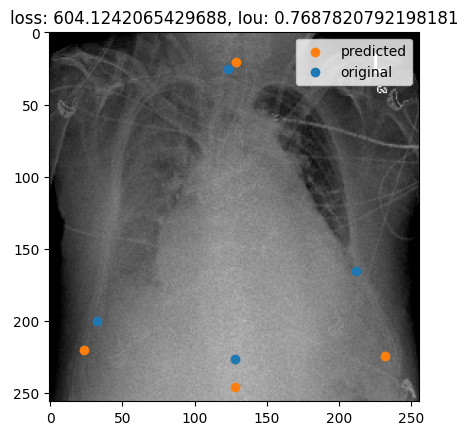

In [ ]:
for i, (image, targ) in enumerate(test_loader):
        if i in [40, 46, 69, 90, 124, 132]:
            img = image.to(device = DEVICE).repeat(1, 3, 1, 1)
            target = targ.to(DEVICE)
            pred = model(img)
            loss = loss_func(pred, target.squeeze(1))
            pred = pred[0].to('cpu').detach().numpy()
            plot_keypoints_IoU(image, targ, pred)
            

Test check

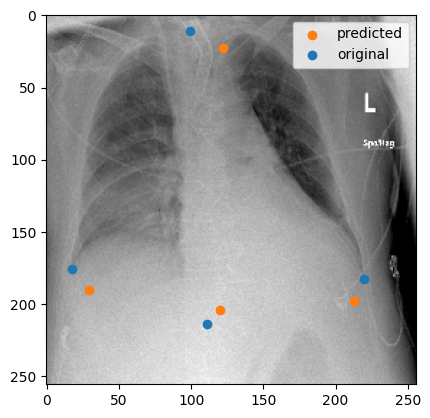

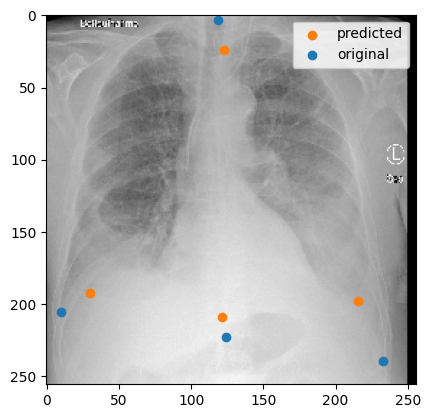

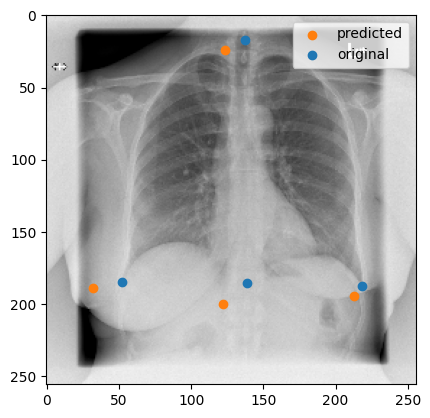

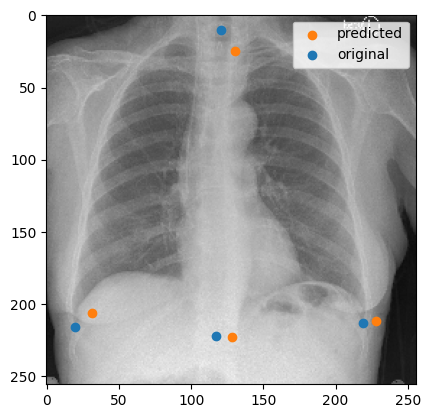

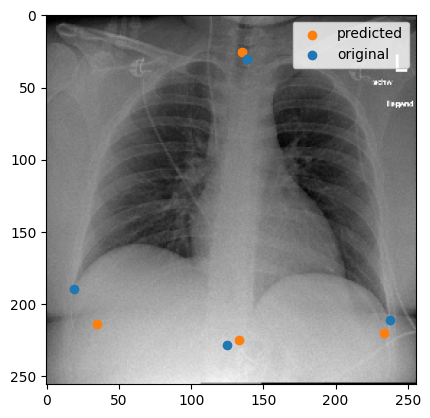

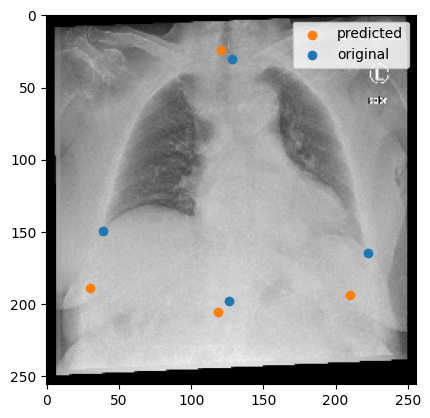

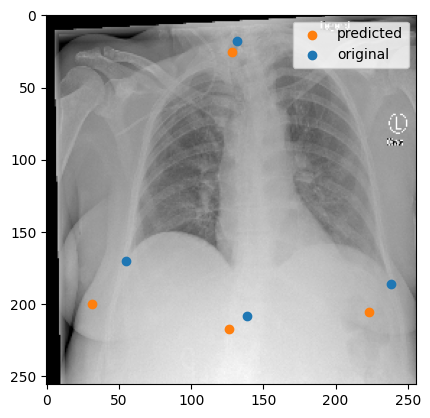

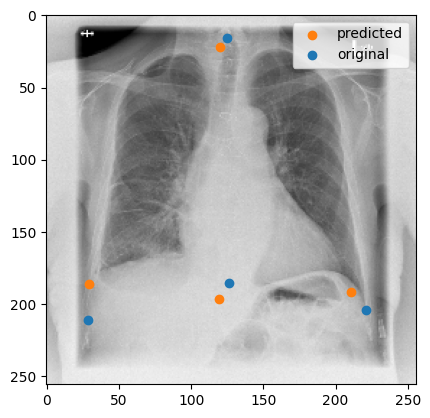

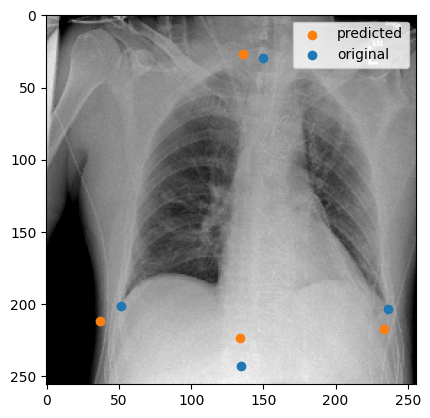

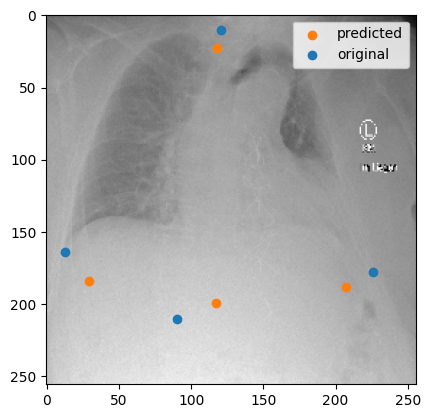

MSE: 244.073388671875
Box IoU: 0.7782710266113281
10


In [ ]:
model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))